# Part A *Document Clustering*


 - Student Name: Akshay Sapra 
 - Stuident ID: 29858186
 
Programming Language used: R in Jupyter Notebook

Libraries Used: 
- tm - for text mining
- snowballC - to support tm

#### Libraries Used

In [1]:
library(tm) # for text mining
library(SnowballC) # to support tm


Warning message:
"package 'tm' was built under R version 3.6.1"Loading required package: NLP


### Load and Explore Data

#### Task I

Derive Expectation and Maximization steps of the hard-EM algorithm for Document
Clustering, show your work in your submitted PDF report. In particular, include all model
parameters that should be learnt and the exact expression (using the same math
convention that we saw in the Module 4) that should be used to update these
parameters during the learning process (ie., E step, M step and assignments).


- PDF report is attched in the zip

#### Task II

Implement the hard-EM (you derived above) and soft-EM (derived in Chapter 5 of
Module 4). Please provide enough comments in your submitted code.
Hint. If it helps, feel free to base your code on the provided code for EM algorithm
for GMM in Activity 4.1 or the codebase provided in the Moodle)

* ##### Auxillary Functions

In [81]:
eps=1e-10
  
## --- helper function ------------------------------------------------------------------ 
# Input:    logA1, logA2 ... logAn
# Output:   log(A1+A2+...+An)
#
# This function is needed to prevent numerical overflow/underflow when working with small numbers, 
# because we can easily get small numbers by multiplying p1 * p2 * ... * pn (where 0 <= pi <= 1 are probabilities).   
#
# Example: Suppose we are interested in p1*p2*p3 + q1*q2+q3 where all numbers are probabilities \in [0,1]
#          To prevent numerical errors, we do the computation in the log space and convert the result back using the exp function 
#          Hence our approach is to form the vector v = [log(p1)+log(p2)+log(p3) , log(q1)+log(q2)+log(q3)] 
#          Then get the results by: exp(logSum(v))

logSum <- function(v) {
   m = max(v)
   return ( m + log(sum(exp(v-m))))
}

##--- Initialize model parameters randomly --------------------------------------------
initial.param <- function(vocab_size, K=4, seed=123456){
  rho <- matrix(1/K,nrow = K, ncol=1)                    # assume all clusters have the same size (we will update this later on)
  mu <- matrix(runif(K*vocab_size),nrow = K, ncol = vocab_size)    # initiate Mu 
  mu <- prop.table(mu, margin = 1)               # normalization to ensure that sum of each row is 1
  return (list("rho" = rho, "mu"= mu))
}



##--- the training objective function --------------------------------------------
# Input: 
#    model:  the model object containing the mu and rho
#    counts: the word-document frequency matrix
# Output:
#    nloglike: the negative log-likelihood i.e. log P(counts|model) 
#   
train_obj <- function(model, counts) { 
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]
   
  nloglike = 0
  for (n in 1:N){
    lprob <- matrix(0,ncol = 1, nrow=K)
    for (k in 1:K){
      lprob[k,1] = sum(counts[,n] * log(model$mu[k,])) 
    }
    nloglike <- nloglike - logSum(lprob + log(model$rho))
  }
  
  return (nloglike)
}


* ##### Soft E step

In [3]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the soft-EM
#
SoftE.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  return (gamma)
}


* ##### Hard E step

In [54]:
##--- E Step for Document Clustering  --------------------------------------------
# this function currently implements the E-step of the Hard-EM
#
HardE.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  K <- dim(model$mu)[1]

  # E step:    
  for (n in 1:N){
    for (k in 1:K){
      ## calculate the posterior based on the estimated mu and rho in the "log space"
      gamma[n,k] <- log(model$rho[k,1]) +  sum(counts[,n] * log(model$mu[k,])) 
    }
    # normalisation to sum to 1 in the log space
    logZ = logSum(gamma[n,])
    gamma[n,] = gamma[n,] - logZ
  }
  
  # converting back from the log space 
  gamma <- exp(gamma)
  # hard assignments:
  max.prob <- gamma==apply(gamma, 1, max) # for each point find the cluster with the maximum (estimated) probability
  gamma[max.prob] <- 0.999999999 # assign each point to the cluster with the highest probability
  gamma[!max.prob] <- 0.0000000001 # remove points from clusters with lower probabilites
  return (gamma)
}


* ##### M Step

In [11]:
##--- M Step for Document Clustering  --------------------------------------------
M.step <- function(gamma, model, counts){
  # Model Parameter Setting
  N <- dim(counts)[2]   # number of documents
  W <- dim(counts)[1]   # number of words i.e. vocabulary size
  K <- dim(model$mu)[1] # number of clusters
    
  for (k in 1:K){
      model$rho[k] <- sum(gamma[,k])/N     # the relative cluster size
      model$mu[k,] <- colSums(gamma[,k] %*%  t(counts))/sum(gamma[,k] %*%  t(counts))  # new means (cluster cenroids)
  }
  #normalising thea vector so that it sums to 1 by adding a small number (eps) to all elements of the vector.
  #first need to add eps to elements [n1+eps,n2+eps,n3+eps], then divide the elements by (n1+n2+n3+ 3*eps) so that the vecotr sums to 1. 
  scale(model$mu+eps,scale =colSums(model$mu+eps), center =F)
  #reference: https://www.r-bloggers.com/r-tutorial-series-centering-variables-and-generating-z-scores-with-the-scale-function/
  
    # Return the result
  return (model)
}

* ##### EM step

In [97]:
##--- EM for Document Clustering --------------------------------------------
EM <- function(counts, K=4, max.epoch=10, seed=123456, isHard=FALSE){
  #INPUTS:
  ## counts: word count matrix
  ## K: the number of clusters
  #OUTPUTS:
  ## model: a list of model parameters
  
  # Model Parameter Setting
  N <- dim(counts)[2] # number of documents
  W <- dim(counts)[1] # number of unique words (in all documents)
  
  # Initialization
  model <- initial.param(W, K=K, seed=seed)
  gamma <- matrix(0, nrow = N, ncol = K)

  print(train_obj(model,counts))
  # Build the model
  for(epoch in 1:max.epoch){
  if (isHard){
      #Hard E step
      gamma <- HardE.step(gamma, model, counts)
  }    
  else
      {       
        # Soft E Step
        gamma <- SoftE.step(gamma, model, counts)
      }
      
    # M Step
    model <- M.step(gamma, model, counts)
   
    print(train_obj(model,counts)) 
  }
  # Return Model
  return(list("model"=model,"gamma"=gamma))
}

##### Task III
Load Task2A.text file and necessary libraries (if needed, perform text preprocessing
similar to what we did in Activity 4.2), set the number of clusters K=4, and run both
the soft-EM and hard-EM algorithms on the provided data

In [7]:
# reading the data
read.data <- function(file.name='./Task2A.txt', sample.size=1000, seed=100, pre.proc=TRUE, spr.ratio= 0.90) {
  # INPUTS:
  ## file.name: name of the input .txt file
  ## sample.size: if == 0  reads all docs, otherwise only reads a subset of the corpus
  ## seed: random seed for sampling (read above)
  ## pre.proc: if TRUE performs the preprocessing (recommended)
  ## spr.ratio: is used to reduce the sparcity of data by removing very infrequent words
  # OUTPUTS:
  ## docs: the unlabled corpus (each row is a document)
  ## word.doc.mat: the count matrix (each rows and columns corresponds to words and documents, respectively)
  ## label: the real cluster labels (will be used in visualization/validation and not for clustering)
  
  # Read the data
  text <- readLines(file.name)
  # select a subset of data if sample.size > 0
  if (sample.size>0){
    set.seed(seed)
    text <- text[sample(length(text), sample.size)]
  }
  ## the terms before the first '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
  docs <- strsplit(text, '\t')
  # store the labels for evaluation
  labels <-  unlist(lapply(docs, function(x) x[1]))
  # store the unlabeled texts    
#   docs <- data.frame(unlist(lapply(docs, function(x) x[2])))
  docs <- data.frame(doc_id = 1:length(docs), text=unlist(lapply(docs, function(x) x[2])))

                        
  # create a corpus
  docs <- DataframeSource(docs)
  corp <- Corpus(docs)
  
  # Preprocessing:
  if (pre.proc){
    corp <- tm_map(corp, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
    corp <- tm_map(corp, removePunctuation) # remove pnctuation
    corp <- tm_map(corp, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
    corp <- tm_map(corp, removeNumbers) # remove all numbers
    corp <- tm_map(corp, stripWhitespace) # remove redundant spaces 
  }  
  # Create a matrix which its rows are the documents and colomns are the words. 
  dtm <- DocumentTermMatrix(corp)
  ## reduce the sparcity of out dtm
  dtm <- removeSparseTerms(dtm, spr.ratio)
  ## convert dtm to a matrix
  word.doc.mat <- t(as.matrix(dtm))
  
  # Return the result
  return (list("docs" = docs, "word.doc.mat"= word.doc.mat, "labels" = labels))
}

In [118]:


### main body ##################################################################

# Reading documents 
## Note: sample.size=0 means all read all documents!
##(for develiopment and debugging use a smaller subset e.g., sample.size = 40)
data <- read.data(file.name='./Task2A.txt', sample.size=0, seed=1234, pre.proc=TRUE, spr.ratio= .99)

# word-document frequency matrix 
counts <- data$word.doc.mat        

# calling the Soft EM algorithm on the data
soft.res <- EM(counts, K=4, max.epoch=5)   
## find the culster with the maximum probability (since we have soft assignment here)
soft.label.hat <- apply(soft.res$gamma, 1, which.max) 
    

# calling the Hard EM algorithm on the data
hard.res <- EM(counts, K=4, max.epoch=5, isHard=TRUE)   
## find the culster with the maximum probability (since we have soft assignment here)
hard.label.hat <- apply(hard.res$gamma, 1, which.max) 
    

[1] 2179748
[1] 1948039
[1] 1928777
[1] 1920030
[1] 1915803
[1] NaN
[1] 2183184
[1] 1950690
[1] 1930186
[1] 1919208
[1] 1913291
[1] 1909878


##### Task IV

Perform a PCA on the clusterings that you get based on the hard-EM and soft-EM in
the same way we did in Activity 4.2. Then, visualize the obtained clusters with
different colors where x and y axes are the first two principal components (similar to
Activity 4.2). Save your visualizations as plots, and attach them to your PDF report.

In [117]:

##--- Cluster Visualization for PCA cluster -------------------------------------------------
cluster.viz <- function(doc.word.mat, color.vector, title=' '){
  p.comp <- prcomp(doc.word.mat, scale. = TRUE, center = TRUE)
  plot(p.comp$x, col=color.vector, pch=1,  main=title)
}
# visualization


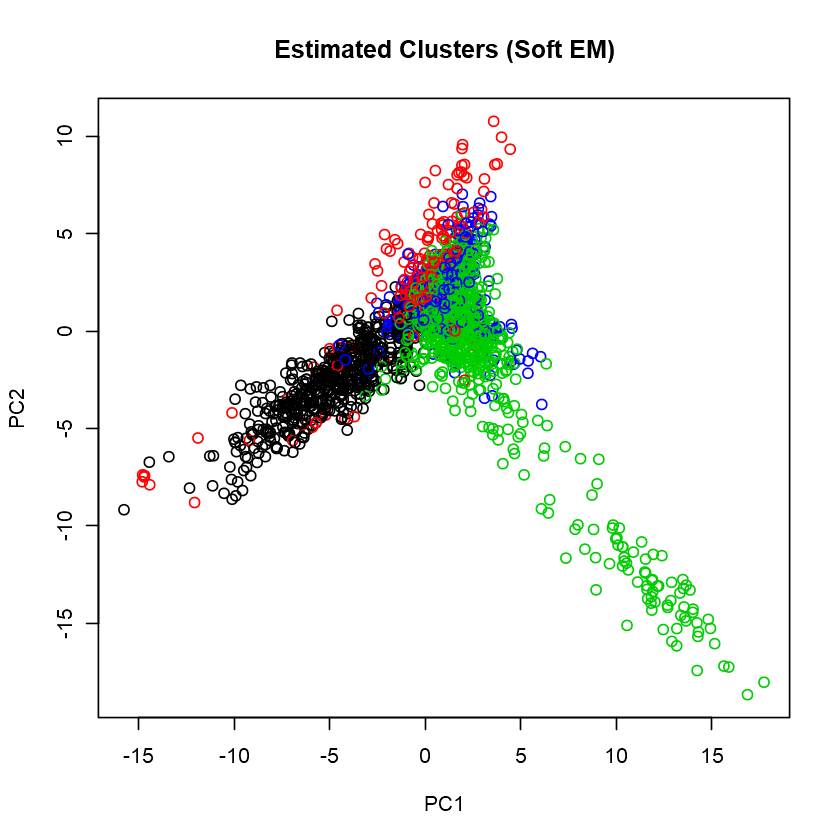

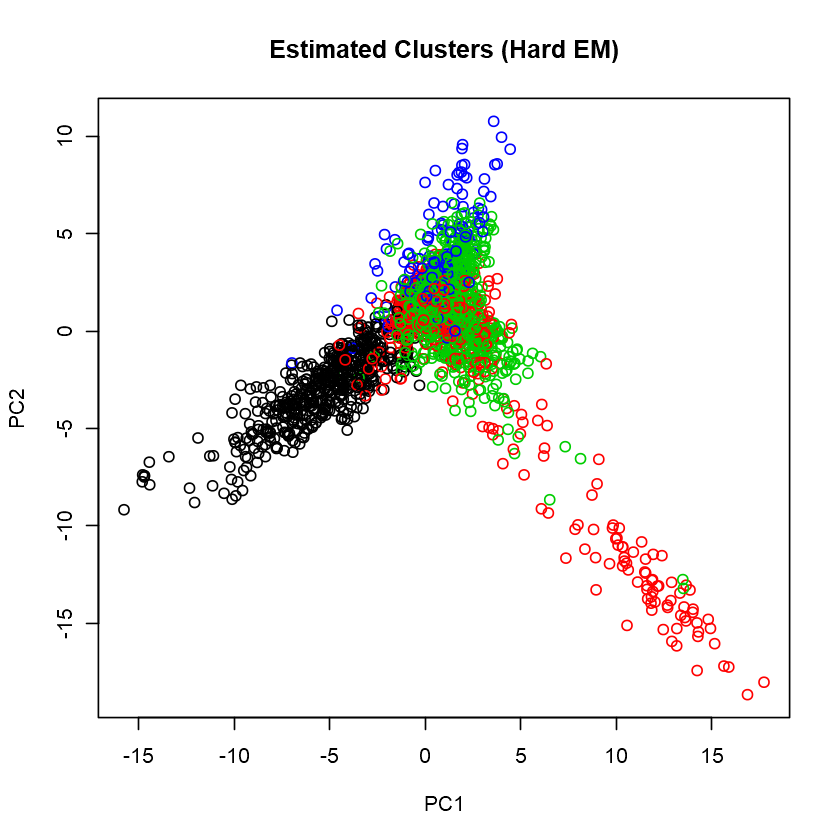

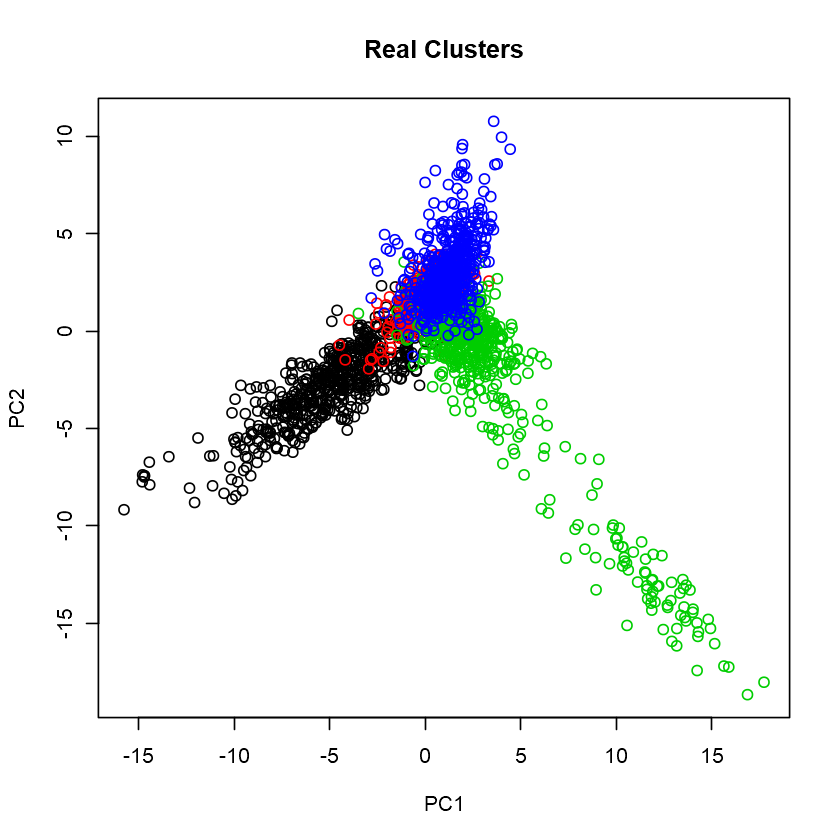

In [119]:

## normalize the count matrix for better visualization
counts<-scale(counts) # only use when the dimensionality of the data (number of words) is large enough

## visualize the stimated clusters
cluster.viz(t(counts), soft.label.hat, 'Estimated Clusters (Soft EM)')

cluster.viz(t(counts), hard.label.hat, 'Estimated Clusters (Hard EM)')


## visualize the real clusters
cluster.viz(t(counts), factor(data$label), 'Real Clusters')
